In [1]:
import src.preprocessing.load_csv as load_csv
import src.preprocessing.plot_data as plot_data
import src.preprocessing.preprocessing_run as preprocessing_run
import src.models.T2_model as T2_model
import src.evaluation.predict as predict
import src.preprocessing.tools as tools
import src.preprocessing.kowalski as kowalski

import importlib
import numpy as np
import pandas as pd

importlib.reload(load_csv)
importlib.reload(plot_data)
importlib.reload(preprocessing_run)
importlib.reload(T2_model)
importlib.reload(predict)
importlib.reload(tools)
importlib.reload(kowalski)

2024-06-10 16:43:00.535310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 16:43:01.309809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'src.preprocessing.kowalski' from '/home/theob/Documents/stage/ML_skyportal/src/preprocessing/kowalski.py'>

In [198]:
kowalski.get_data_from_kowalski(nb_obj=20)

Connected to Kowalski
Total number of objects: 20
0 ZTF17aaaeqms 0.0
1 ZTF17aaajowi 0.05
2 ZTF17aaanztg 0.1
3 ZTF17aaaocnx 0.15
4 ZTF17aaaptxx 0.2
5 ZTF17aaapufz 0.25
6 ZTF17aaazdba 0.3
7 ZTF17aabgaoo 0.35
8 ZTF17aabhmby 0.4
9 ZTF17aabtvsy 0.45
10 ZTF17aabwkio 0.5
11 ZTF17aacldgo 0.55
12 ZTF17aacpbmv 0.6
13 ZTF17aacxacr 0.65
14 ZTF17aadlxmv 0.7
15 ZTF18aaaecnk 0.75
16 ZTF18aaaehwv 0.8
17 ZTF18aaahyvk 0.85
18 ZTF18aaaibml 0.9
19 ZTF18aaajljy 0.95


# Load data

In [4]:
import os
path = 'data_kowalski/'
objIds = os.listdir(path)

photo_df, object_alerts = kowalski.load_kowalski_data(objIds[0], path)

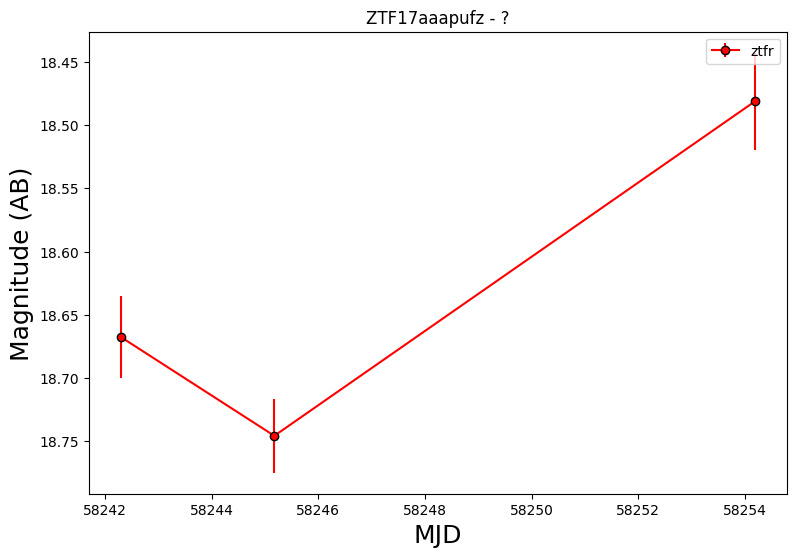

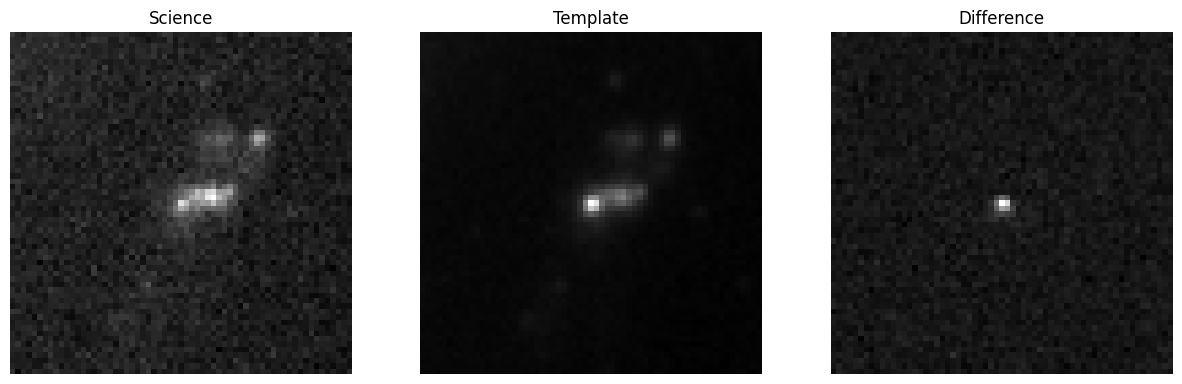

       objectId  sgscore1  sgscore2  distpsnr1  distpsnr2  fwhm     magpsf  \
0  ZTF17aaapufz   0.06775       0.5   0.086062   0.999845  2.13  18.474344   

   sigmapsf         ra        dec  diffmaglim  ndethist  nmtchps  ncovhist  \
0  0.037255  188.96785  27.932071   20.660788        64       19        93   

   sharpnr      scorr       sky  
0    0.173  34.774063 -0.516451  
71


In [7]:
one_photo, one_metatda, one_image, index = kowalski.get_data(photo_df, object_alerts, index=0)
plot_data.plot_all(one_photo, one_metatda, one_image)
print(index)

In [8]:
photo_path = 'data/photometry_Other_SN_I_SN_II.csv'
metadata_path = 'data/train_cand_ZTFSS.csv'
images_path = 'data/train_triplets_ZTFSS.npy'

In [73]:
photo_df, cand, triplets, objIds = load_csv.load_all_data(
    photo_path=photo_path,
    metadata_path=metadata_path,
    images_path=images_path)

# Get one Object

Real Type: SN I


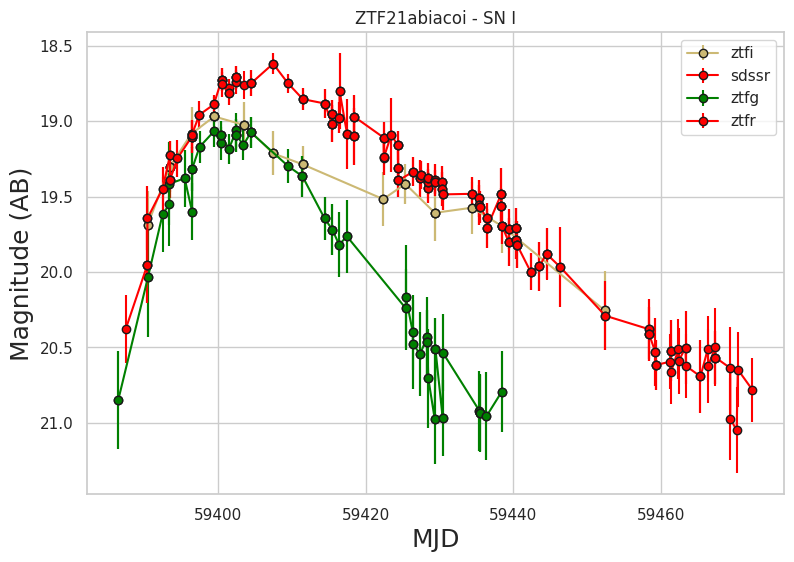

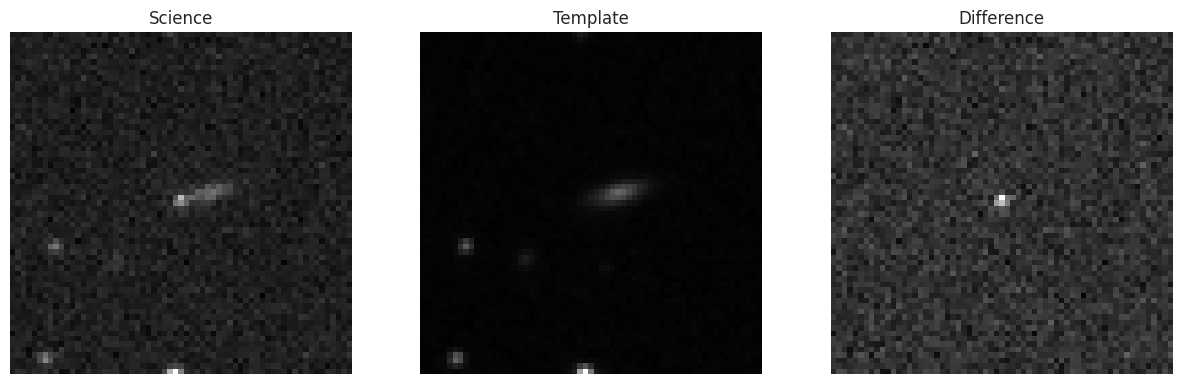

          objectId  sgscore1  sgscore2  distpsnr1  distpsnr2  fwhm     magpsf  \
2658  ZTF21abiacoi       0.5  0.079667   3.863606   5.488948  2.44  19.101063   

      sigmapsf          ra        dec  diffmaglim  ndethist  nmtchps  \
2658  0.108618  353.842368  25.417153   19.937595        17        6   

           drb  ncovhist  sharpnr      scorr       sky  
2658  0.999949       847    0.476  16.198828  0.318429  


In [74]:
objId = 'ZTF21abiacoi'
#objId = load_csv.get_objId(objIds)

one_photo, one_cand, one_image = load_csv.get_data(objId, photo_df, cand, triplets)
real_type = one_photo['type'].iloc[0]
print(f"Real Type: {real_type}")
plot_data.plot_all(one_photo, one_cand, one_image)

# Preprocessing

100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


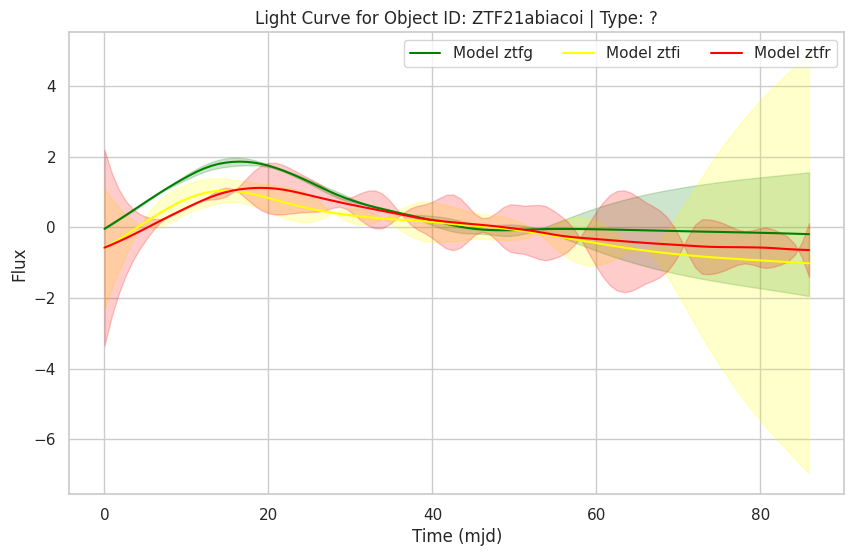

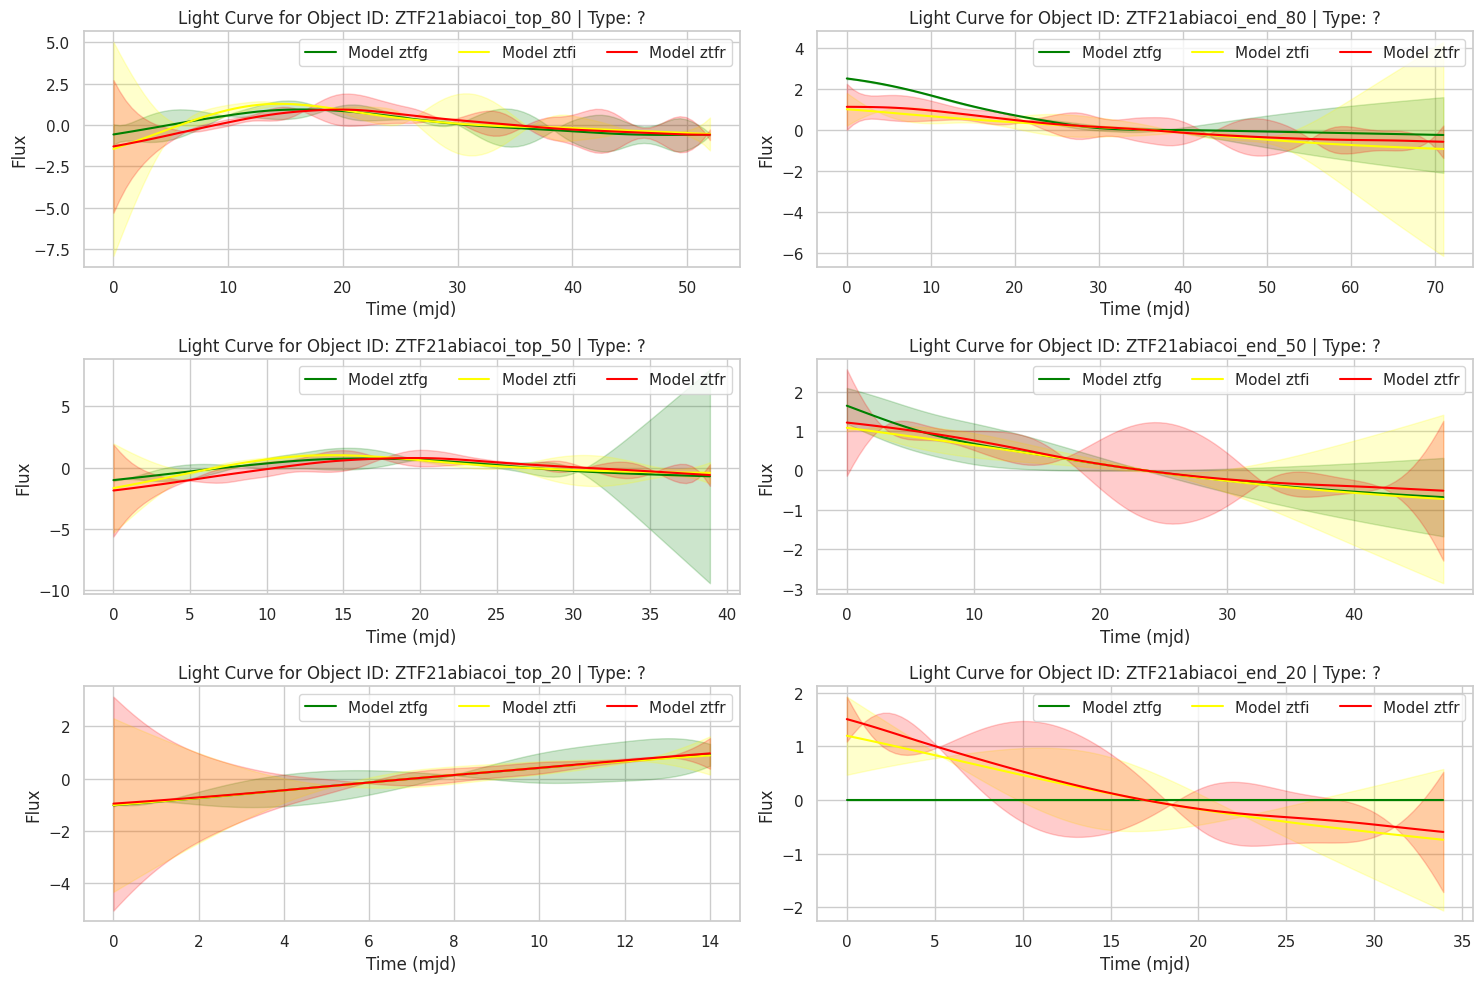

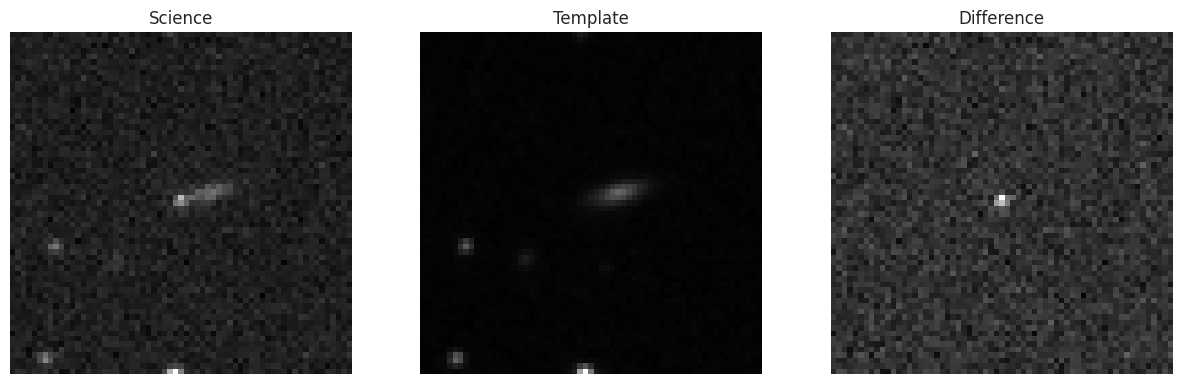

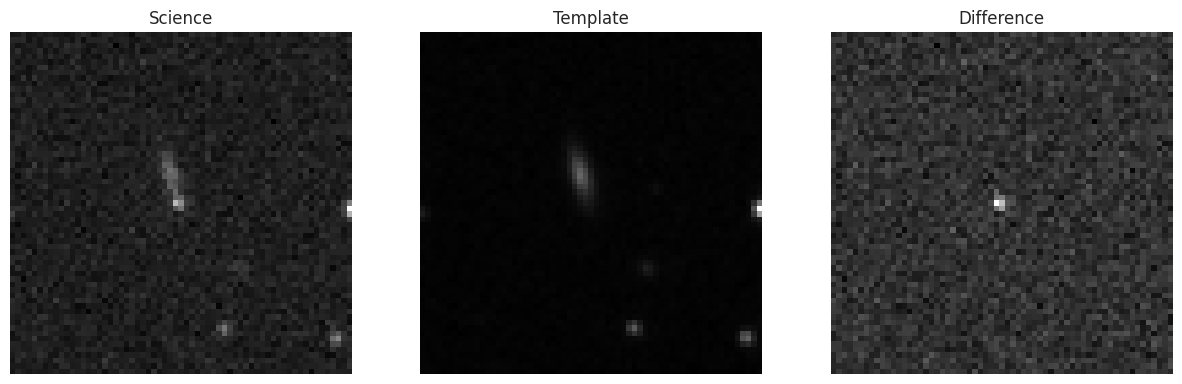

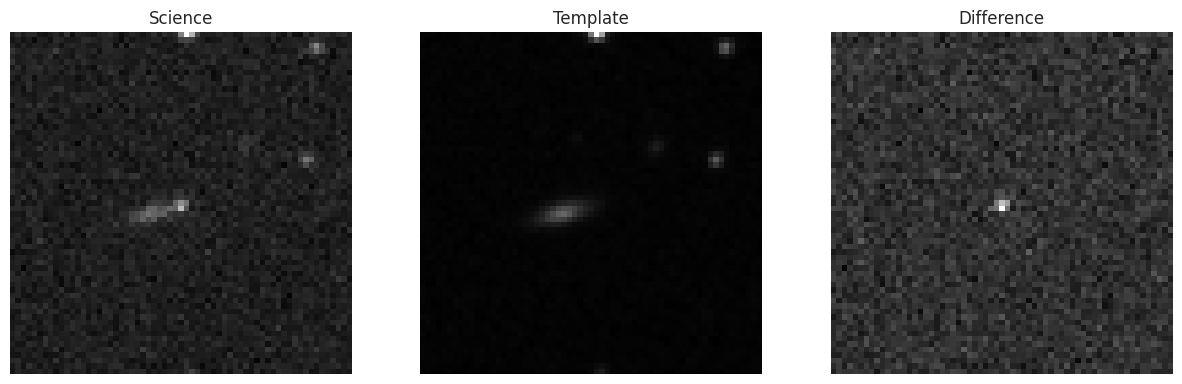

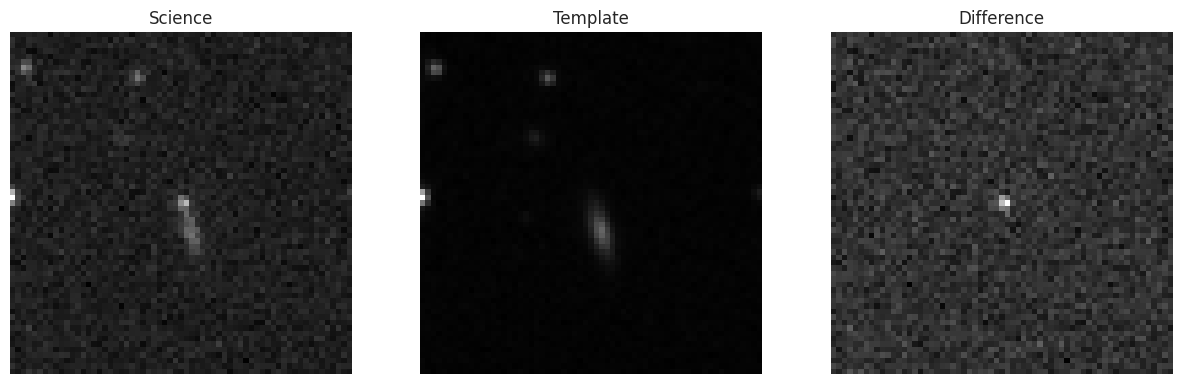

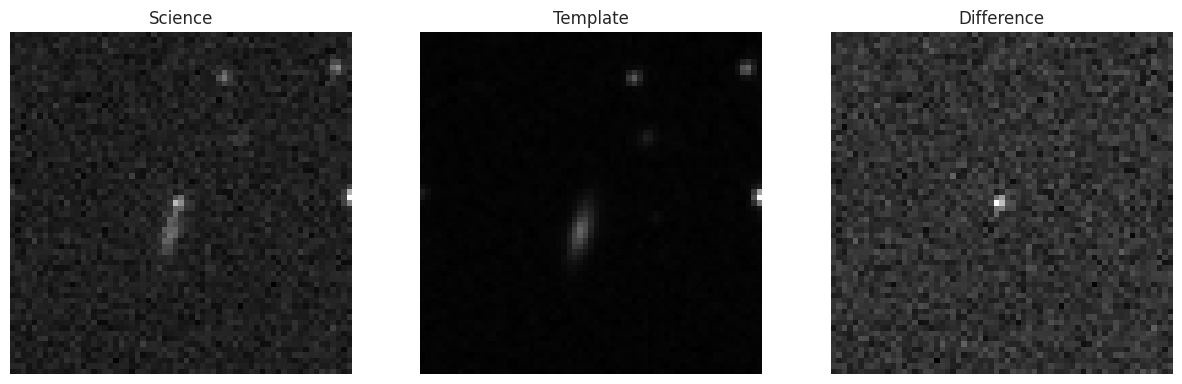

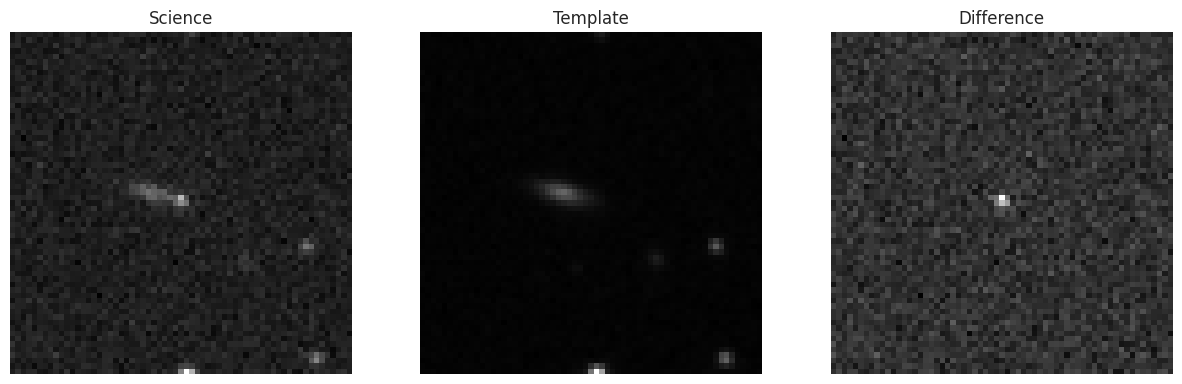

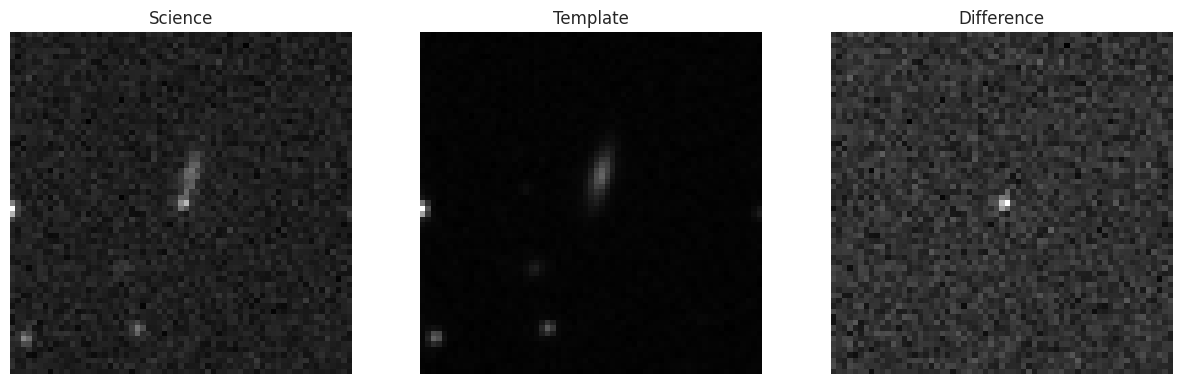

In [75]:
photo_ready, cand_ready, image_ready = preprocessing_run.process_data(one_photo, one_cand, one_image, verbose=True)

# Load model

In [76]:
from tensorflow.keras.optimizers import Adam

num_filters = 64
num_classes = 2
num_layers = 1
d_model = 64
num_heads = 16
dff = 128
rate = 0.5

shapes = [(100, 4), (17,), (63, 63, 3)]

# Initialize the T2Model with the proper configuration
model = T2_model.T2Model(num_filters=num_filters, num_classes=num_classes, num_layers=num_layers,
                d_model=d_model, num_heads=num_heads, dff=dff, input_shapes=shapes, 
                rate=rate)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Creating the final model instance
model.build(input_shapes=shapes)

# Print the model summary
model.summary()

model.load_weights('checkpoints/step_1.weights.h5')

Model: "t2_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ multimodal_model_3              │ (None, 1)              │       226,805 │
│ (MultimodalModel)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_embedding_3                │ (None, 100, 64)        │           832 │
│ (ConvEmbedding)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_3           │ (None, 100, 64)        │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 100, 64)        │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 65)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_7 (Concatenate)     │ (None, 65)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,241 (1020.47 KB)

 Trainable params: 261,207 (1020.34 KB)

 Non-trainable params: 34 (136.00 B)

/home/theob/anaconda3/envs/ml_skyportal_env/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [77]:
final_data = predict.predict_classes(photo_ready, cand_ready, image_ready)

# Predict and display

In [78]:
y_pred, y_pred_classes = predict.predict_T2(final_data, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


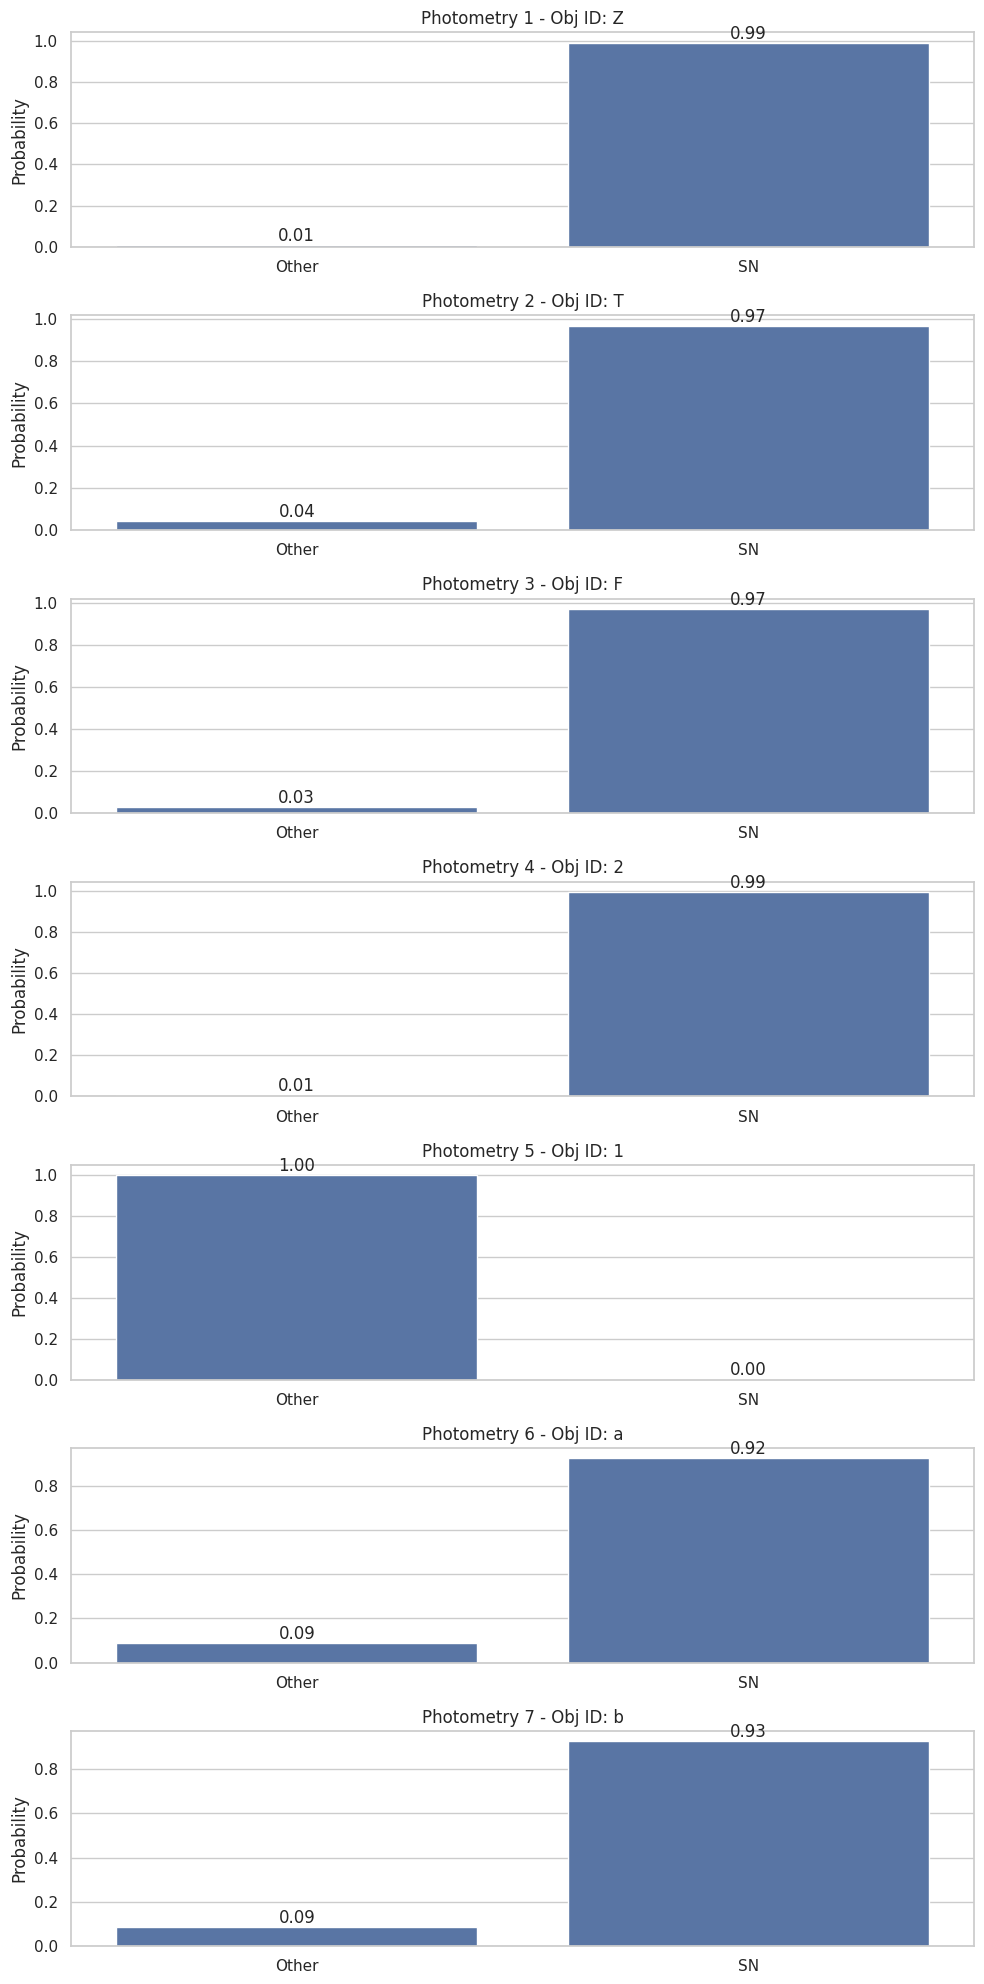

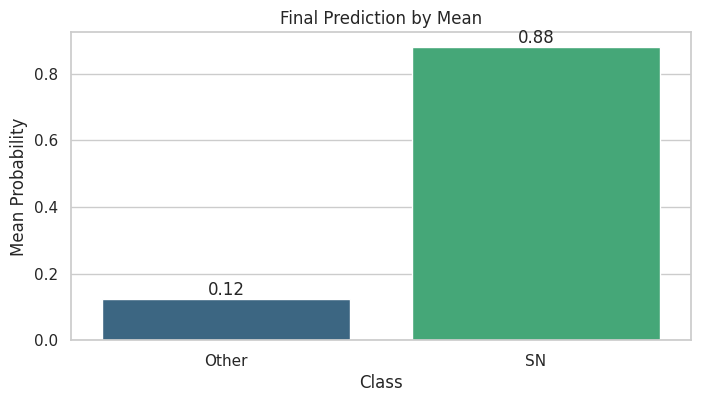

Final Prediction by Mean: [0.12439686 0.87983845]
Final Class by Voting: SN


In [79]:
types = ['Other', 'SN']

predict.display_predictions(y_pred, objId, types)
weights = np.array([0.4, 0.15, 0.15, 0.1, 0.1, 0.05, 0.05])

weights = weights[:y_pred.shape[0]]

final_prediction = predict.weighted_average_predictions(y_pred, weights)
if final_prediction is not None:
    predict.final_prediction_display(final_prediction, types)
    final_class = np.argmax(final_prediction)
    print(f"Final Prediction by Mean:", final_prediction)
    print(f"Final Class by Voting:", types[final_class])
else:
    print("No valid predictions available.")

# Predict random obj

Real Type: SN I


100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


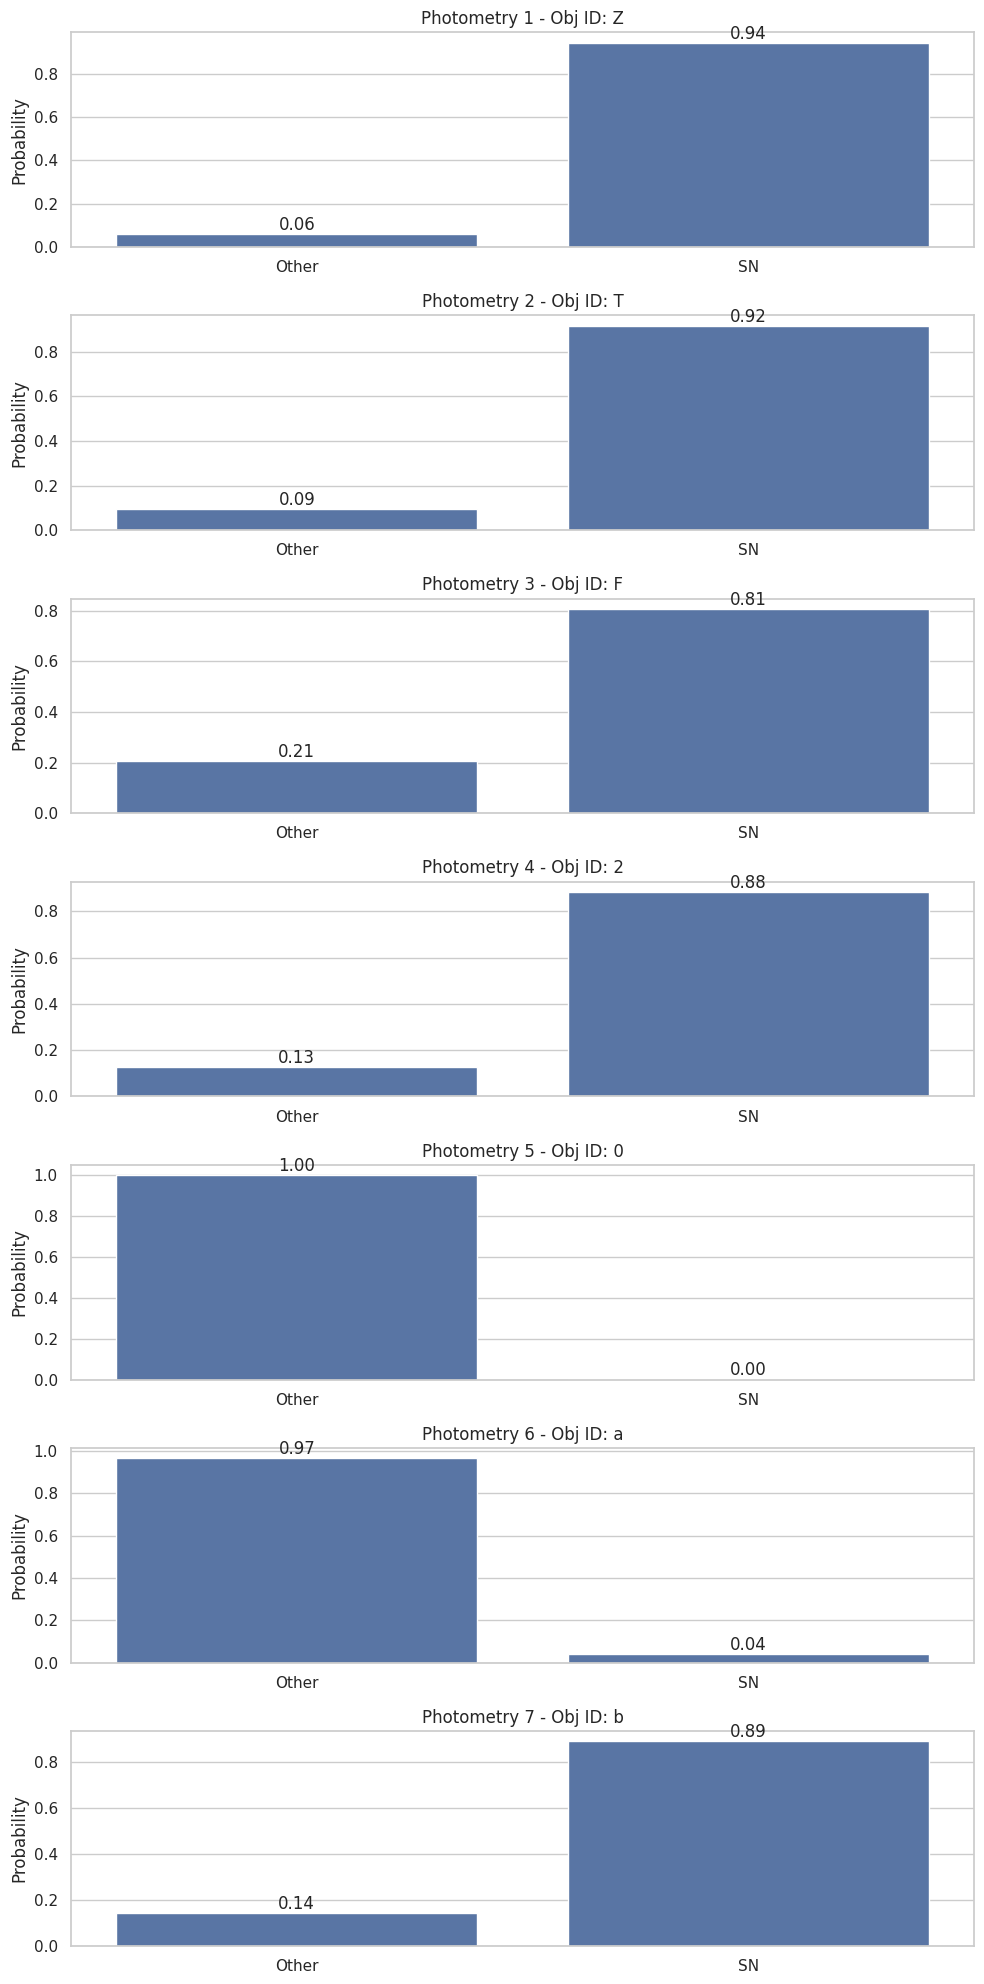

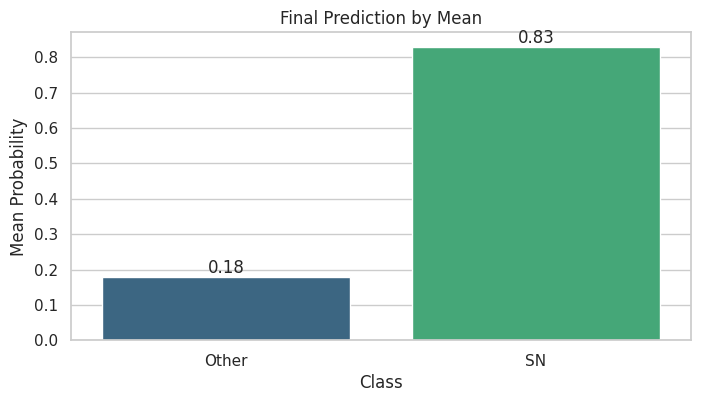

Final Prediction by Mean: [0.17900502 0.82930341]
Final Class by Voting: SN
Predicted Type: SN | Real Type: SN I


In [80]:
objId = load_csv.get_objId(objIds)
one_photo, one_cand, one_image = load_csv.get_data(objId, photo_df, cand, triplets)

real_type = one_photo['type'].iloc[0]
print(f"Real Type: {real_type}")

photo_ready, cand_ready, image_ready = preprocessing_run.process_data(one_photo, one_cand, one_image)
photo_ready.head()

final_data = predict.predict_classes(photo_ready, cand_ready, image_ready)

y_pred, y_pred_classes = predict.predict_T2(final_data, model)

predict.display_predictions(y_pred, objId, types)

weights = np.array([0.6, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05])
weights = weights / np.sum(weights)
types = ['Other', 'SN']

final_prediction = predict.weighted_average_predictions(y_pred, weights)
if final_prediction is not None:
    predict.final_prediction_display(final_prediction, types)
    final_class = np.argmax(final_prediction)
    print(f"Final Prediction by Mean:", final_prediction)
    print(f"Final Class by Voting:", types[final_class])
else:
    print("No valid predictions available.")

print(f'Predicted Type: {types[final_class]} | Real Type: {real_type}')

# Predict and calculate success rate

In [83]:
obj_ids = objIds[:20]

In [88]:
from tqdm import tqdm

def calculate_success_rate(objIds, photo_df, cand, triplets, model, treshold=0.6):
    total_objects = len(objIds)
    successful_predictions = 0
    successful_high_confidence_predictions = 0
    high_confidence_predictions = 0
    incorrect_predictions = []
    confidence_correct = []
    confidence_incorrect = []
    logs = []

    types = ['Other', 'SN']
    weights = np.array([0.6, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05])
    weights = weights / np.sum(weights)

    for objId in tqdm(objIds, desc="Processing Objects"):
        try:
            one_photo, one_cand, one_image = load_csv.get_data(objId, photo_df, cand, triplets)
            
            real_type = one_photo['type'].iloc[0].split()[0]

            photo_ready, cand_ready, image_ready = preprocessing_run.process_data(one_photo, one_cand, one_image)

            final_data = predict.predict_classes(photo_ready, cand_ready, image_ready)

            y_pred, y_pred_classes = predict.predict_T2(final_data, model)

            if y_pred.size == 0:
                logs.append(f"No valid predictions available for objId: {objId}")
                continue

            final_prediction = predict.weighted_average_predictions(y_pred, weights)
            if final_prediction is not None:
                final_class = np.argmax(final_prediction)
                prediction_type = types[final_class]
                confidence = final_prediction[final_class]
                success = prediction_type == real_type
                status = 'V' if success else 'X'
                logs.append(f"{status} | Final Prediction: {final_prediction} | Predicted: {prediction_type} | Real: {real_type} | Confidence: {confidence:.2f}")
                if success:
                    successful_predictions += 1
                    confidence_correct.append(confidence)
                    if confidence > treshold:
                        successful_high_confidence_predictions += 1
                else:
                    incorrect_predictions.append((final_prediction, prediction_type, real_type))
                    confidence_incorrect.append(confidence)
                if confidence > treshold:
                    high_confidence_predictions += 1
            else:
                logs.append(f"X | No valid predictions available for objId: {objId}")
        except Exception as e:
            logs.append(f"Error processing objId {objId}: {e}")
            
    success_rate = (successful_predictions / total_objects) * 100 if total_objects > 0 else 0
    high_confidence_success_rate = (successful_high_confidence_predictions / high_confidence_predictions) * 100 if high_confidence_predictions > 0 else 0
    average_confidence_correct = np.mean(confidence_correct) if confidence_correct else 0
    average_confidence_incorrect = np.mean(confidence_incorrect) if confidence_incorrect else 0

    summary = [
        f"Success Rate: {success_rate}%",
        f"Success Rate for High Confidence Predictions (>{treshold*100}%): {high_confidence_success_rate}%",
        f"Average Confidence for Correct Predictions: {average_confidence_correct:.2f}",
        f"Average Confidence for Incorrect Predictions: {average_confidence_incorrect:.2f}"
    ]

    if incorrect_predictions:
        summary.append("\nIncorrect Predictions Analysis:")
        for pred, predicted, real in incorrect_predictions:
            summary.append(f"Predicted: {predicted}, Real: {real}, Prediction: {pred}")

    return success_rate, high_confidence_success_rate, average_confidence_correct, average_confidence_incorrect, logs, summary

success_rate, high_confidence_success_rate, avg_conf_correct, avg_conf_incorrect, logs, summary = calculate_success_rate(obj_ids, photo_df, cand, triplets, model, treshold=0.7)


100%|██████████| 1/1 [00:00<00:00, 22.30it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|██████████| 1/1 [00:00<00:00, 32.71it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|██████████| 1/1 [00:00<00:00, 31.53it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|██████████| 1/1 [00:00<00:00, 41.23it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|██████████| 1/1 [00:00<00:00, 50.65it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|██████████| 1/1 [00:00<00:00, 48.28it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|██████████| 1/1 [00:00<00:00, 28.45it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|██████████| 1/1 [00:00<00:00, 36.53it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|██████████| 1/1 [00:00<00:00, 43.86it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


100%|██████████| 1/1 [00:00<00:00, 22.40it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|██████████| 1/1 [00:00<00:00, 36.93it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|██████████| 1/1 [00:00<00:00, 42.30it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|██████████| 1/1 [00:00<00:00, 43.62it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Objects: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


In [90]:
for i in summary:
    print(i)

print(success_rate, high_confidence_success_rate, avg_conf_correct, avg_conf_incorrect)

Success Rate: 80.0%
Success Rate for High Confidence Predictions (>70.0%): 80.0%
Average Confidence for Correct Predictions: 0.81
Average Confidence for Incorrect Predictions: 0.73

Incorrect Predictions Analysis:
Predicted: SN, Real: Other, Prediction: [0.25221372 0.74828475]
Predicted: Other, Real: SN, Prediction: [0.68826112 0.2862121 ]
Predicted: SN, Real: Other, Prediction: [0.24735779 0.75779569]
Predicted: SN, Real: Other, Prediction: [0.31409596 0.71507047]
80.0 80.0 0.811865097153678 0.7273530086802793


# Search the best treshold

In [91]:
import numpy as np
from tqdm import tqdm

def predict_calculate(objIds, photo_df, cand, triplets, model):
    total_objects = len(objIds)
    all_predictions = []

    types = ['Other', 'SN']
    weights = np.array([0.6, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05])
    weights = weights / np.sum(weights)

    for objId in tqdm(objIds, desc="Processing Objects"):
        try:
            one_photo, one_cand, one_image = load_csv.get_data(objId, photo_df, cand, triplets)
            real_type = one_photo['type'].iloc[0].split()[0]

            photo_ready, cand_ready, image_ready = preprocessing_run.process_data(one_photo, one_cand, one_image)
            final_data = predict.predict_classes(photo_ready, cand_ready, image_ready)
            y_pred, y_pred_classes = predict.predict_T2(final_data, model)

            if y_pred.size == 0:
                continue

            final_prediction = predict.weighted_average_predictions(y_pred, weights)
            if final_prediction is not None:
                final_class = np.argmax(final_prediction)
                prediction_type = types[final_class]
                confidence = final_prediction[final_class]
                success = prediction_type == real_type
                all_predictions.append((final_prediction, success))
        except Exception as e:
            print(f"Error processing objId {objId}: {e}")
            
    return all_predictions

all_predictions = predict_calculate(obj_ids, photo_df, cand, triplets, model)

def analyze_thresholds(predictions, thresholds):
    results = []
    for threshold in thresholds:
        total_predictions = len(predictions)
        successful_predictions = 0
        high_confidence_predictions = 0

        for final_prediction, success in predictions:
            confidence = max(final_prediction)
            if confidence > threshold:
                high_confidence_predictions += 1
                if success:
                    successful_predictions += 1
        
        success_rate = (successful_predictions / total_predictions) * 100 if total_predictions > 0 else 0
        high_confidence_success_rate = (successful_predictions / high_confidence_predictions) * 100 if high_confidence_predictions > 0 else 0
        
        results.append({
            'threshold': threshold,
            'success_rate': success_rate,
            'high_confidence_success_rate': high_confidence_success_rate,
            'total_predictions': total_predictions,
            'successful_predictions': successful_predictions,
            'high_confidence_predictions': high_confidence_predictions
        })
    return results

thresholds = np.arange(0.0, 1.0, 0.05)
analysis_results = analyze_thresholds(all_predictions, thresholds)

for result in analysis_results:
    print(f"Threshold: {result['threshold']:.2f}, Success Rate: {result['success_rate']:.2f}%, High Confidence Success Rate: {result['high_confidence_success_rate']:.2f}%")


100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|██████████| 1/1 [00:00<00:00, 52.00it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|██████████| 1/1 [00:00<00:00, 30.55it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|██████████| 1/1 [00:00<00:00, 29.86it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|██████████| 1/1 [00:00<00:00, 39.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|██████████| 1/1 [00:00<00:00, 28.20it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


100%|██████████| 1/1 [00:00<00:00, 35.89it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|██████████| 1/1 [00:00<00:00, 38.74it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|██████████| 1/1 [00:00<00:00, 28.46it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|██████████| 1/1 [00:00<00:00, 31.60it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|██████████| 1/1 [00:00<00:00, 43.97it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|██████████| 1/1 [00:00<00:00, 25.37it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Objects: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

Threshold: 0.00, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.05, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.10, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.15, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.20, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.25, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.30, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.35, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.40, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.45, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.50, Success Rate: 80.00%, High Confidence Success Rate: 80.00%
Threshold: 0.55, Success Rate: 75.00%, High Confidence Success Rate: 78.95%
Threshold: 0.60, Success Rate: 75.00%, High Confidence Success Rate: 78.95%
Threshold: 0

In [20]:
import urllib
import os
import requests     
import json
import numpy as np
import pandas as pd

from penquins import Kowalski
from dotenv import load_dotenv

load_dotenv()

api_token = os.getenv("FRITZ_API_TOKEN")
kowalski_token = os.getenv("KOWALSKI_API_TOKEN")

if not api_token or not kowalski_token:
    print("Tokens not found in .env file")
    exit()

host = "https://fritz.science/"
headers = {'Authorization': f'token {api_token}'}

instances = {'kowalski': {'protocol': 'https', 'port': 443, 'host': f'kowalski.caltech.edu', 'token': kowalski_token,}} 
kowalski = Kowalski(instances=instances)
if kowalski.ping(name="kowalski"):
    print("Connected to Kowalski")
else:
    print("Unable to connect to Kowalski")
    exit() 

dataDir = "data_kowalski/"

df_bts = pd.read_csv('data/BTS.csv')
objIds = sorted(list(set(df_bts["ZTFID"])))

objIds = objIds[:10]

print(f"Total number of objects: {len(objIds)}")

for ii, objId in enumerate(objIds):
    print(ii, objId, float(ii / len(objIds)))

    objDirectory = os.path.join(dataDir, objId)
    if not os.path.isdir(objDirectory):
        os.makedirs(objDirectory)
    else:
        continue

    endpoint = f"sources/{objId}/photometry"                               
    url = urllib.parse.urljoin(host, f'/api/{endpoint}') 
    r = requests.get(url, headers=headers) 
    photometry = r.json()['data'] 
    photometryFile = os.path.join(objDirectory, 'photometry.json') 
    with open(photometryFile, 'w') as fp:  
        json.dump(photometry, fp)

    endpoint = f"sources/{objId}/spectra"
    url = urllib.parse.urljoin(host, f'/api/{endpoint}')
    r = requests.get(url, headers=headers)
    spectra = r.json()['data']
    spectraFile = os.path.join(objDirectory, 'spectra.json')
    with open(spectraFile, 'w') as fp:
        json.dump(spectra, fp)

    query = {
        "query_type": "find",
        "query": {
            "catalog": "ZTF_alerts",
            "filter": {
                # take only alerts for specified object
                'objectId': objId,
            },
            # what quantities to recieve 
            "projection": {
                "_id": 0,
                "objectId": 1,

                "candidate.candid": 1,
                "candidate.programid": 1,
                "candidate.fid": 1,
                "candidate.isdiffpos": 1,
                "candidate.ndethist": 1,
                "candidate.ncovhist": 1,
                "candidate.sky": 1,
                "candidate.fwhm": 1,
                "candidate.seeratio": 1,
                "candidate.mindtoedge": 1,
                "candidate.nneg": 1,
                "candidate.nbad": 1,
                "candidate.scorr": 1,
                "candidate.dsnrms": 1,
                "candidate.ssnrms": 1,
                "candidate.exptime": 1,

                "candidate.field": 1,
                "candidate.jd": 1,
                "candidate.ra": 1,
                "candidate.dec": 1,

                "candidate.magpsf": 1,
                "candidate.sigmapsf": 1,
                "candidate.diffmaglim": 1,
                "candidate.magap": 1,
                "candidate.sigmagap": 1,
                "candidate.magapbig": 1,
                "candidate.sigmagapbig": 1,
                "candidate.magdiff": 1,
                "candidate.magzpsci": 1,
                "candidate.magzpsciunc": 1,
                "candidate.magzpscirms": 1,

                "candidate.distnr": 1,
                "candidate.magnr": 1,
                "candidate.sigmanr": 1,
                "candidate.chinr": 1,
                "candidate.sharpnr": 1,

                "candidate.neargaia": 1,
                "candidate.neargaiabright": 1,
                "candidate.maggaia": 1,
                "candidate.maggaiabright": 1,

                "candidate.drb": 1,
                "candidate.classtar": 1,
                "candidate.sgscore1": 1,
                "candidate.distpsnr1": 1,
                "candidate.sgscore2": 1,
                "candidate.distpsnr2": 1,
                "candidate.sgscore3": 1,
                "candidate.distpsnr3": 1,

                "candidate.jdstarthist": 1,
                "candidate.jdstartref": 1,

                "candidate.sgmag1": 1,
                "candidate.srmag1": 1,
                "candidate.simag1": 1,
                "candidate.szmag1": 1,

                "candidate.sgmag2": 1,
                "candidate.srmag2": 1,
                "candidate.simag2": 1,
                "candidate.szmag2": 1,

                "candidate.sgmag3": 1,
                "candidate.srmag3": 1,
                "candidate.simag3": 1,
                "candidate.szmag3": 1,

                "candidate.nmtchps": 1,
                "candidate.clrcoeff": 1,
                "candidate.clrcounc": 1,
                "candidate.chipsf": 1,

                "classifications.acai_h": 1,
                "classifications.acai_v": 1,
                "classifications.acai_o": 1,
                "classifications.acai_n": 1,
                "classifications.acai_b": 1,

                "cutoutScience": 1,
                "cutoutTemplate": 1,
                "cutoutDifference": 1,
            }
        }
    }

    r = kowalski.query(query)
    object_alerts = r["kowalski"]['data']
    alertsFile = os.path.join(objDirectory, 'alerts.npy') 
    np.save(alertsFile, object_alerts)

Connected to Kowalski
Total number of objects: 10
0 ZTF17aaaeqms 0.0
1 ZTF17aaajowi 0.1
2 ZTF17aaanztg 0.2
3 ZTF17aaaocnx 0.3
4 ZTF17aaaptxx 0.4
5 ZTF17aaapufz 0.5
6 ZTF17aaazdba 0.6
7 ZTF17aabgaoo 0.7
8 ZTF17aabhmby 0.8
9 ZTF17aabtvsy 0.9


In [170]:
def load_kowalski_data(objId, path):

    objDirectory = os.path.join(path, objId)

    photo_df = pd.read_json(os.path.join(objDirectory, 'photometry.json'))
    photo_df = photo_df[['obj_id', 'mjd', 'mag', 'magerr', 'snr', 'limiting_mag', 'filter']]
    photo_df['type'] = "?"
    photo_df['jd'] = photo_df['mjd'] + 2400000.5
    photo_df = photo_df.dropna(subset=['mag', 'magerr'])
    photo_df = photo_df.drop_duplicates()
    photo_df = photo_df.reset_index(drop=True)

    alertsFile = os.path.join(objDirectory, 'alerts.npy')
    object_alerts = np.load(alertsFile, allow_pickle=True)

    return photo_df, object_alerts

In [171]:
import os
path = 'data_kowalski/'
objIds = os.listdir(path)

print(objIds)

['ZTF17aaapufz', 'ZTF17aabgaoo', 'ZTF17aabhmby', 'ZTF17aaanztg', 'ZTF17aabtvsy', 'ZTF17aaaeqms', 'ZTF17aaazdba', 'ZTF17aaaocnx', 'ZTF17aaajowi', 'ZTF17aaaptxx']


In [172]:
photo_df, object_alerts = load_kowalski_data(objIds[0], path)

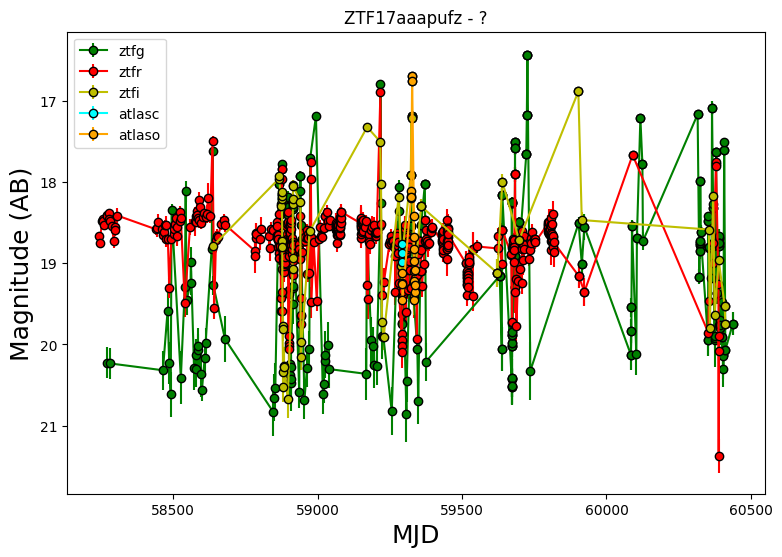

In [173]:
plot_data.plot_photometry(photo_df)

In [183]:
from astropy.io import fits
import gzip
import io

def decompress_fits(data):
    compressed_data = gzip.decompress(data)
    with fits.open(io.BytesIO(compressed_data), ignore_missing_end=True) as hdul:
        return hdul[0].data

def process_alert(alert):
    # metadata
    metadata = alert['candidate']
    metadata_df = pd.DataFrame([metadata])
    metadata_df['objectId'] = alert['objectId']
    columns_metadata = [
        "objectId",
        "sgscore1", "sgscore2", 
        "distpsnr1", "distpsnr2", 
        "fwhm", 
        "magpsf", 
        "sigmapsf", 
        "ra", 
        "dec", 
        "diffmaglim", 
        "ndethist", 
        "nmtchps", 
        "ncovhist", 
        "sharpnr", 
        "scorr", 
        "sky"
    ]
    metadata_df = metadata_df[columns_metadata]

    # images
    cutout_science = decompress_fits(alert['cutoutScience']['stampData'])
    cutout_template = decompress_fits(alert['cutoutTemplate']['stampData'])
    cutout_difference = decompress_fits(alert['cutoutDifference']['stampData'])

    assembled_image = np.stack((cutout_science, cutout_template, cutout_difference), axis=-1)

    return metadata_df, assembled_image

In [190]:
def get_first_valid_index(photometry, object_alertes):
    for i, alert in enumerate(object_alertes):
        jd_current = alert['candidate']['jd']
        photometry_filtered = photometry[photometry['jd'] < jd_current]

        filters_to_check = ['ztfr', 'ztfg', 'ztfi']
        for filt in filters_to_check:
            if (photometry_filtered['filter'] == filt).sum() >= 3:
                return i
    
    return -1

def cut_photometry(photometry, object_alertes, index):
    jd_current = object_alertes[index]['candidate']['jd']
    photometry_filtered = photometry[photometry['jd'] < jd_current]
    return photometry_filtered

def get_data(photometry, object_alerts, index=0):

    first_index = get_first_valid_index(photometry, object_alerts)
    if first_index == -1:
        return None, None
    
    if index < first_index:
        index = first_index

    photometry_filtered = cut_photometry(photometry, object_alerts, index)
    alert = object_alerts[index]

    metadata_df, assembled_image = process_alert(alert)
    return photometry_filtered, metadata_df, assembled_image

In [191]:
photo_1, metatda_df, images = get_data(photo_df, object_alerts)

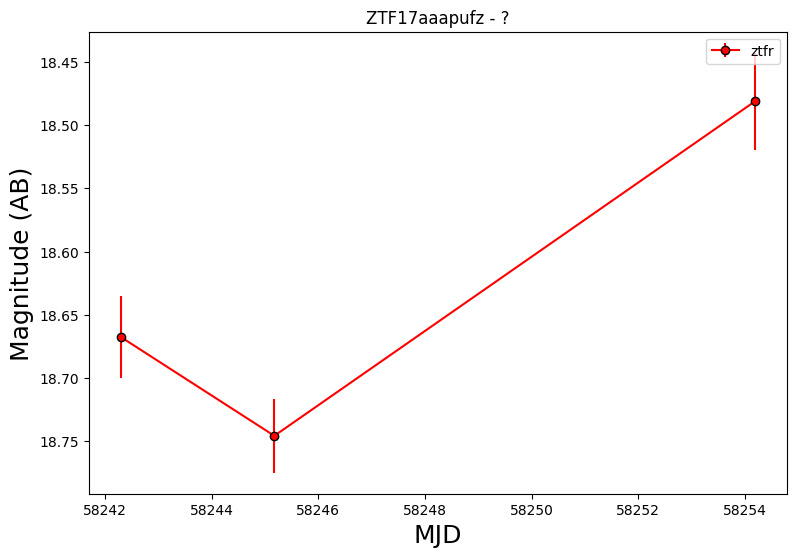

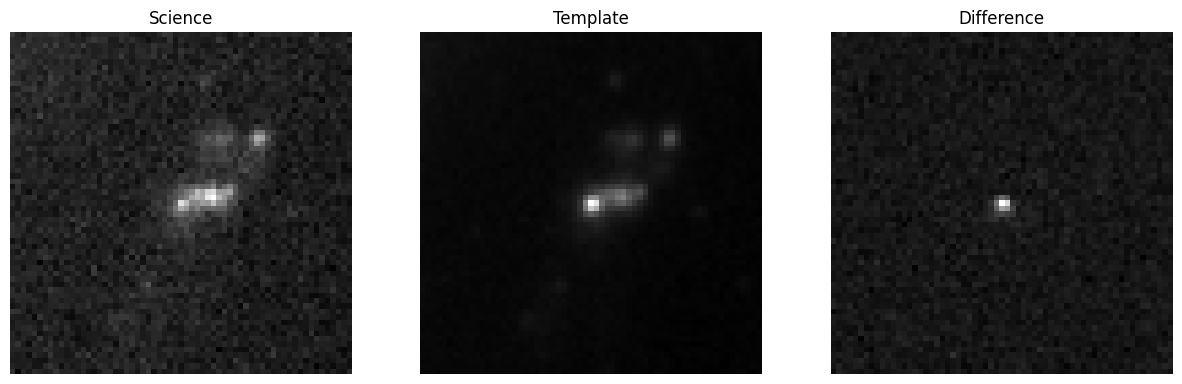

       objectId  sgscore1  sgscore2  distpsnr1  distpsnr2  fwhm     magpsf  \
0  ZTF17aaapufz   0.06775       0.5   0.086062   0.999845  2.13  18.474344   

   sigmapsf         ra        dec  diffmaglim  ndethist  nmtchps  ncovhist  \
0  0.037255  188.96785  27.932071   20.660788        64       19        93   

   sharpnr      scorr       sky  
0    0.173  34.774063 -0.516451  


In [193]:
plot_data.plot_all(photo_1, metatda_df, images)

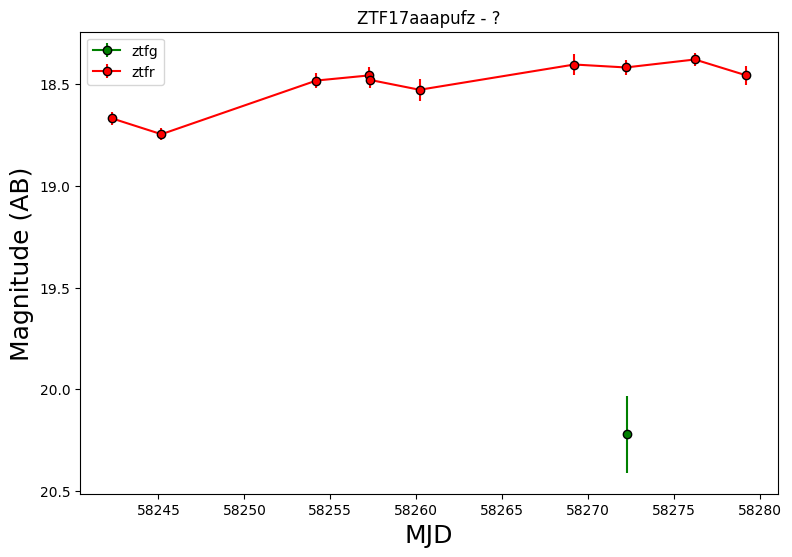

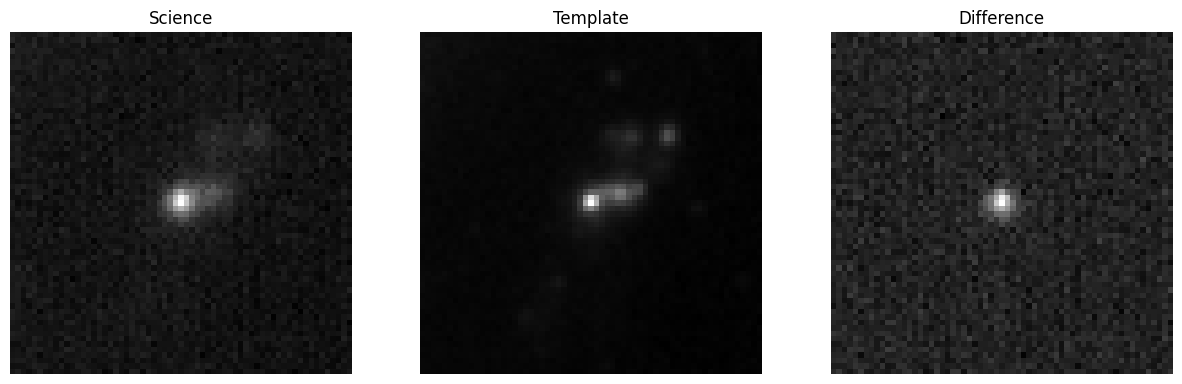

       objectId  sgscore1  sgscore2  distpsnr1  distpsnr2  fwhm     magpsf  \
0  ZTF17aaapufz   0.06775       0.5   0.229796   0.849283  4.12  17.663441   

   sigmapsf          ra       dec  diffmaglim  ndethist  nmtchps  ncovhist  \
0  0.053138  188.967881  27.93204    19.78352      1023       19      1967   

   sharpnr      scorr      sky  
0    0.173  35.413357 -0.44951  


In [195]:
photo_df, metatda_df, images = get_data(photo_df, object_alerts, index=900)
plot_data.plot_all(photo_df, metatda_df, images)